# Notebook 4 (Analysis Notebook)

In this notebook we will use the [Presidential Job Approval Rating](http://www.presidency.ucsb.edu/data/popularity.php) from UCSB as a response variable to evaluate our model. And then we do a sentiment anaylsis of Trump and Obama twitter data by using the Sentiment Anaylzer from the NLTK package. We use the sentiment anaylsis to get the positive and negative on their tweets , and compare their sentiment by the twitter data. We will also use the sentiment anaylsis as a predictor variable. Then, we will test it with R-squared to see the correlation between the predictors variables and response variable. Lastly, we will use the OLS regresion to find out whether the Approval Rating can be predicted.


In [1]:
import warnings
import pandas as pd
pd.options.display.max_rows = 999
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import string
import shelve
from datetime import datetime
from datetime import timedelta
import nltk
nltk.download('vader_lexicon')
from nltk import sentiment
import statsmodels.formula.api as sm
from p3funcs import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Jim\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


C:\Users\Jim\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [72]:
#Input the data from notebook 1
with shelve.open('result/vars1') as db:
    obama = db['obama_raw']
    trump = db['trump_raw']

## Get the Presidential Job Approval Rating from [UCSB Website](http://www.presidency.ucsb.edu/data/popularity.php).

Since we only have about 10 months data on President Trump and Obama started using twitter frequently in Aug 2014.

In [3]:
#data scraping for trump
warnings.filterwarnings('ignore')
url_2017 ='http://www.presidency.ucsb.edu/data/popularity.php'
#get the raw dataset
raw_2017 = pd.read_html(url_2017)[0]
raw_2017 = raw_2017.iloc[:,1:6]
raw_2017 = raw_2017.drop(raw_2017.columns[2], axis = 1)
#data cleaning
data_2017 = raw_2017.iloc[106:378,:].reset_index(drop=True)
data_2017.columns = ['start', 'end', 'approval', 'disapproval']
data_2017.approval = data_2017.approval.convert_objects(convert_numeric=True)
data_2017.disapproval = data_2017.disapproval.convert_objects(convert_numeric=True)
data_2017.start = [datetime.strptime(data_2017.start[i], '%m/%d/%Y') for i in range(len(data_2017.start))]
data_2017.end = [datetime.strptime(data_2017.end[i], '%m/%d/%Y') for i in range(len(data_2017.end))]
#cleaned_data
data_2017.head()
#save for further use
data_2017.to_hdf('result/n4.h5','trumpapproval',table=True,mode='a')

We want to see the time domin for Trump so that we can perform the same time domin for Obama.

In [4]:
(data_2017.iloc[1].end - data_2017.iloc[-1].start).days

276

This website contains all the approval data from jan 21st 2009 to jan 19th 2017. So it may take sevral minutes to retrieve the data

In [5]:
#data scraping for obama
url_2009 = 'http://www.presidency.ucsb.edu/data/popularity.php?pres=44&sort=time&direct=DESC&Submit=DISPLAY'
raw_2009 = pd.read_html(url_2009)[0]
raw_2009 = raw_2009.iloc[:,1:6]
raw_2009 = raw_2009.drop(raw_2009.columns[2], axis = 1)

We first want to know the index of the day that Obama first tweets and add the days we got from Trump as end date. By doing this, we can get the one year time domain for Obama then narrow down to 276 days.

In [6]:
#Perform the same time domin for Obama and Trump
warnings.filterwarnings('ignore')
raw_2009.columns = ['start', 'end', 'approval', 'disapproval']
raw_2009.approval = raw_2009.approval.convert_objects(convert_numeric=True)
raw_2009.disapproval = raw_2009.disapproval.convert_objects(convert_numeric=True)

Now we want to know column of the starting date for Obama 

In [7]:
raw_2009.loc[lambda raw_2009: raw_2009.iloc[:,0] == '08/14/2014', :]

,start,end,approval,disapproval
904,08/14/2014,08/16/2014,41.0,53.0


Now we want to know column of one year after starting date.

In [8]:
raw_2009.loc[lambda raw_2009: raw_2009.iloc[:,1] == '08/14/2015', :]

,start,end,approval,disapproval
557,08/12/2015,08/14/2015,45.0,49.0


We can see the 904th column is the starting day and the 557th column is the one year after the starting day. Then we will extract the one year data set. And we will get 276 days from the starting day of the one year data set(Since we only have 276 days tweets for Trump)

In [9]:
data_2009 = raw_2009.iloc[557:905,:].reset_index(drop=True)
data_2009.start = [datetime.strptime(data_2009.start[i], '%m/%d/%Y') for i in range(len(data_2009.start))]
data_2009.end = [datetime.strptime(data_2009.end[i], '%m/%d/%Y') for i in range(len(data_2009.end))]
data_2009.iloc[-1].start + timedelta(days=276)

Timestamp('2015-05-17 00:00:00')

From the above output, we can see the May 17, 2015 is 276 days after the starting day(08/14/2014). So we will set May 17, 2015 as the ending day.

In [10]:
#set the ending date = 17/05/2015
data_2009.loc[lambda data_2009: data_2009.iloc[:,1] == '17/05/2015', :]
data_2009 = data_2009.iloc[87:,:].reset_index(drop=True)
data_2009.head()
#save the data for further use
data_2009.to_hdf('result/n4.h5','obamaapproval',table=True,mode='a')

# Sentiment Analysis
An anaylsis of Trump and Obama twitter data by using the Sentiment Anaylzer from the NLTK package. We use the sentiment anaylsis to get the positive and negative on their tweets , and compare their sentiment by the twitter data. 

#### The VADER algorithm outputs sentiment scores to 4 classes of sentiments
The sentiment score from 0 to 1 measuring the subjectivness of the text. 0 is objective, 1 is subjective.
- Postive:The score of measuring positive words
- Negative:The score of measuring negative words
- Neutral:The score of neutral words
- Compound: The aggregated score which is normalized of the sum of all scores .



In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#function of getting the sentiment value
def get_sentiment(tbl,text):
    """
    description: analyze the sentiment of sentence
    input:sentence
    output:sentiment value   
    """
    compound = []
    neg = []
    neu = []
    pos = []
    for i in range(len(text)):
        analyzer = SentimentIntensityAnalyzer()
        answer = analyzer.polarity_scores(text[i])
        compound.append(answer['compound'])
        neg.append(answer['neg'])
        neu.append(answer['neu'])
        pos.append(answer['pos'])
    tbl['compound'] = compound
    tbl['negative'] = neg
    tbl['neutral'] = neu
    tbl['positive'] = pos
    return tbl

We will use the above function to get the sentiment score of both Trump and Obama tweets.

In [ ]:
trump = get_sentiment(trump, trump.text)
obama = get_sentiment(obama, obama.text)
#set created_at as the time
obama.set_index('created_at', inplace=True)
trump.set_index('created_at', inplace=True)
obama.head()

Since the time frames of the Twitter data set and the Approvl Rating data set are different. 
We wrote a function to match the time frames between two data sets. 

In [23]:
def merge_pd(df_1,df_2):
    """This function is designed to help us find the corresponding mean of likes, retweets, favorites for a specific time interval
       tbl1: the first table that contains two columns which is start and end
       tbl2: the second table that has a column of time that we can use to compare to the first table.
             tbl2 should also contains columns of number of replies, retweets, and favorites
       This functoion returns a table with all the corresponding values
    """
    df1=df_1
    df2=df_2
    df1=df1.resample('D').mean()
    df2['Date'] = pd.to_datetime(df2['end'])
    df2.set_index('Date', inplace=True)
    df2=df2[['approval','disapproval']]
    df3=df1.merge(df2,left_index=True, right_index=True)
    df3=df3[pd.notnull(df3.replies)]
    return df3

In [24]:
#Matching the Time Frame for obama
warnings.filterwarnings('ignore')
#using the above function to match the time frame
obama_approval = merge_pd(obama,data_2009)
#save for further use
obama_approval.to_hdf('result/n4.h5','obama',table=True,mode='a')
obama_approval.head()

,replies,retweets,favorites,compound,negative,neutral,positive,approval,disapproval
2014-08-16,622.500000,1011.500000,1598.00,0.180600,0.0000,0.9240,0.0760,41.0,53.0
2014-08-18,495.000000,628.000000,1062.00,0.000000,0.0000,1.0000,0.0000,42.0,51.0
2014-08-19,310.250000,560.000000,954.25,0.123475,0.0000,0.9310,0.0690,43.0,51.0
2014-08-20,366.333333,465.333333,878.00,0.000000,0.0000,1.0000,0.0000,44.0,50.0
2014-08-21,295.000000,418.200000,856.00,0.242980,0.0144,0.9014,0.0842,43.0,50.0


In [29]:
#Matching the Time Frame for obama
warnings.filterwarnings('ignore')
#using the above function to match the time frame
trump_approval = merge_pd(trump,data_2017)
#trump_approval = trump_approval.dropna(axis= 0, how='any')
#trump_approval = trump_approval[trump_approval.like!=0]
#save for further use
trump_approval.to_hdf('result/n4.h5','trump',table=True,mode='a')
trump_approval.head()

,replies,retweets,favorites,compound,negative,neutral,positive,approval,disapproval
2017-01-22,47357.000,47756.750,236872.750,0.244400,0.12225,0.61825,0.25975,45,45
2017-01-23,26338.000,26519.000,175962.000,0.493900,0.00000,0.83300,0.16700,45,46
2017-01-24,22872.000,21478.500,122587.750,0.354225,0.00000,0.87075,0.12925,46,45
2017-01-25,28308.375,29658.125,137332.625,0.126525,0.09300,0.75475,0.15250,46,45
2017-01-26,18345.300,19227.100,95867.300,0.099200,0.09290,0.76070,0.14640,45,48


In [31]:
#Extract the Sentiment Value for analysis
trump_compound = np.asarray(trump_approval.iloc[:,3])
trump_neg = np.asarray(trump_approval.iloc[:,4])
trump_neu = np.asarray(trump_approval.iloc[:,5])
trump_pos = np.asarray(trump_approval.iloc[:,6])

obama_compound = np.asarray(obama_approval.iloc[:,3])
obama_neg = np.asarray(obama_approval.iloc[:,4])
obama_neu = np.asarray(obama_approval.iloc[:,5])
obama_pos = np.asarray(obama_approval.iloc[:,6])

#### Exploring the Sentiment Analysis

Let take a look at the summary of the Sentiment Analysis for Obama

In [149]:
obama_describe=obama_approval[['compound','negative','neutral','positive']].describe()
obama_describe.to_hdf('result/n4.h5','obama_describe',table=True,mode='a')
obama_describe

,compound,negative,neutral,positive
count,231.000000,231.000000,231.000000,231.000000
mean,0.221540,0.031501,0.838107,0.130397
std,0.220897,0.038648,0.080143,0.080087
min,-0.624900,0.000000,0.648600,0.000000
25%,0.079325,0.000000,0.780350,0.075333
50%,0.214380,0.023762,0.836571,0.122000
75%,0.377946,0.049250,0.894833,0.188500
max,0.817600,0.254000,1.000000,0.348000


*From the above result, we can see the compound value is 0.221540. The mean of neutral is much higher than negative and positive. And the mean of postive is still higher than negative. His tweets trend to neutral and a bit positive.*

Let take a look at the summary of the Sentiment Analysis for Trump

In [150]:
trump_describe=trump_approval[['compound','negative','neutral','positive']].describe()
trump_describe.to_hdf('result/n4.h5','trump_describe',table=True,mode='a')
trump_describe

,compound,negative,neutral,positive
count,269.000000,269.000000,269.000000,269.000000
mean,0.218289,0.076704,0.746446,0.176851
std,0.309979,0.062250,0.084951,0.089902
min,-0.921100,0.000000,0.472000,0.000000
25%,0.000000,0.025625,0.706500,0.123500
50%,0.219709,0.074200,0.747500,0.166600
75%,0.425900,0.110900,0.791200,0.223000
max,0.950100,0.422000,1.000000,0.528000


*From the above result, we can see the compound value is 0.218289. The mean of neutral is much higher than negative and positive. And the mean of postive is still higher than negative. His tweets also trend to neutral and a bit positive.*

##### Comparing the the result of Trump and Obama
From the above results, we can see the compound value is for trump is 0.218 while obama is 0.221. The means of postive and negative value of Trump's tweet are higher than Obama. Obama's mean of neutral is higher than Trump. Therefore, we can see Obama' tweets trend to neutral .


### Visualization of the Sentiment Analysis

Let's see the count of postive and negative tweets for both

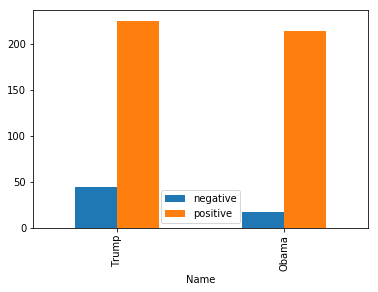

In [34]:
d = {'Name':['Trump','Obama'],'negative': [44, 17], 'positive': [len(trump_pos)-44, len(obama_pos)-17]}
comparison = pd.DataFrame(data=d)
comparison.set_index('Name').plot.bar()
plt.savefig('fig/comparison.png');

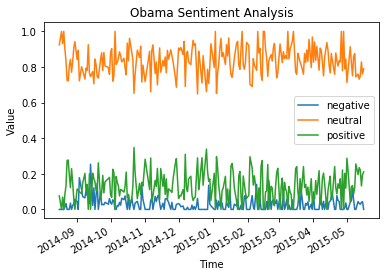

In [86]:

obama_plot = obama_approval[['negative','neutral','positive']]
plt.figure(); obama_plot.plot();
plt.xlabel('Time')
plt.title('Obama Sentiment Analysis')
plt.ylabel('Value')
plt.savefig('fig/Obama_Sentiment_Analysis.png');

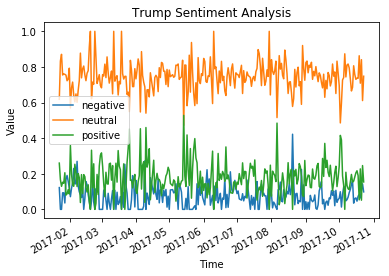

In [87]:
trump_plot = trump_approval[['negative','neutral','positive']]
plt.figure(); trump_plot.plot();
plt.xlabel('Time')
plt.title('Trump Sentiment Analysis')
plt.ylabel('Value')
plt.savefig('fig/Trump_Sentiment_Analysis.png');

# Analysis of Tweeter Data by OLS
We will use the Approval Rating as the response variables. We will show the correlation matrix and test it with R-squared to see the correlation between the predictors variables and response variable. Lastly. we will use OLS for testing.

Let's see the correlation matrix of Obama

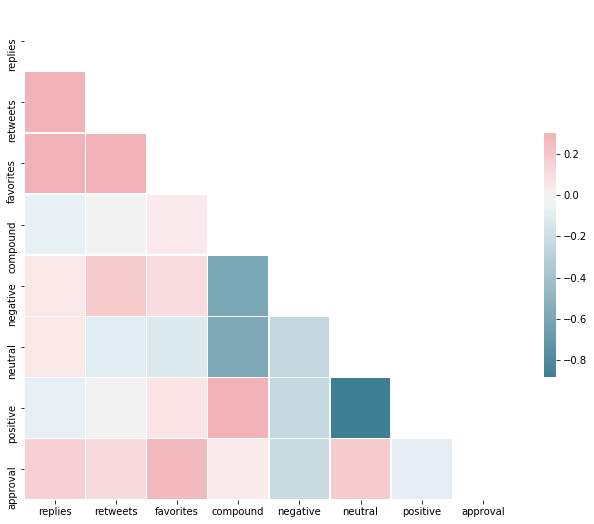

In [54]:
obama_cor= obama_approval.drop('disapproval', 1)
corr1 = obama_cor.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr1, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('fig/obama_cor.png')

Let's see the correlation matrix of Trump

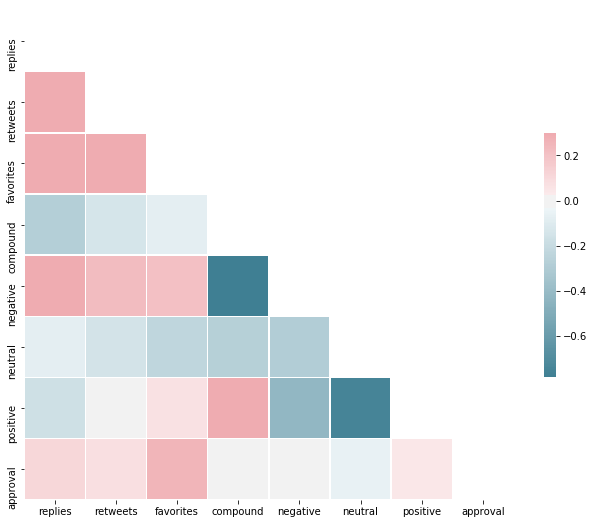

In [55]:
trump_cor= trump_approval.drop('disapproval', 1)
corr2 = trump_cor.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('fig/trump_cor.png')

Plot the Approval Rating, Compound and Favorites(Standardized the data)

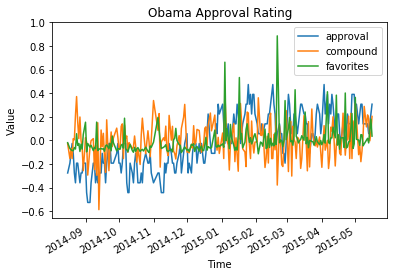

In [74]:
obama_plot = obama_approval[['approval','compound',"favorites"]]
#standardize the data
obama_plot= (obama_plot - obama_plot.mean()) / (obama_plot.max() - obama_plot.min())
plt.figure(); obama_plot.plot();
plt.ylim(ymax=1)

plt.xlabel('Time')
plt.title('Obama Approval Rating')
plt.ylabel('Value')
plt.savefig('fig/Obama_approval_relation.png');

Plot the Approval Rating and other variable for Trump

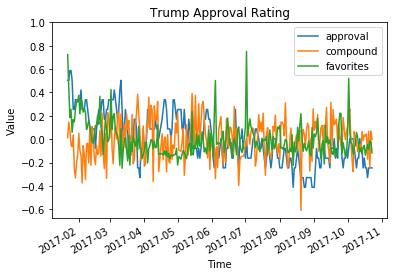

In [75]:
trump_plot = trump_approval[['approval','compound',"favorites"]]
#standardize the data
trump_plot=(trump_plot - trump_plot.mean()) / (trump_plot.max() - trump_plot.min())
plt.figure(); trump_plot.plot();
plt.ylim(ymax=1)

plt.xlabel('Time')
plt.title('Trump Approval Rating')
plt.ylabel('Value')
plt.savefig('fig/Trump_approval_relation.png');

## OLS regression
We will run a OLS regression by using the Approval Rating as predictors variables and other variables as response variable.

### OLS regression for obama

In [97]:

result1 =sm.ols(formula="approval~ compound+ favorites + replies + retweets", data=obama_cor).fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:               approval   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     10.57
Date:                Wed, 13 Dec 2017   Prob (F-statistic):           7.27e-08
Time:                        20:46:21   Log-Likelihood:                -541.96
No. Observations:                 231   AIC:                             1094.
Df Residuals:                     226   BIC:                             1111.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     43.5047      0.464     93.772      0.0

As we can see the r-squared is 0.158 which is really small. It cannot show there is a significant correlation between the predictor variables and the response variable. P-value for Compound (0.703) and Replies (0.718) are much greater than the common alpha level of 0.05, which indicates that it is not statistically significant. Coefficient for Favorites( 0.0019) and Retweets(-0.0020) are really small which may not be statistically significant. It also indicatesthat there are
strong multicollinearity or other numerical problems, it probably caused by the replies, favorites , retweets. Because most people do these three things at the same time, and there is a strong correlation between these three things. 

### OLS regression for Trump

In [95]:
result2 =sm.ols(formula="approval~ compound + favorites + replies + retweets", data=trump_cor).fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:               approval   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     10.71
Date:                Wed, 13 Dec 2017   Prob (F-statistic):           4.63e-08
Time:                        20:45:46   Log-Likelihood:                -612.73
No. Observations:                 269   AIC:                             1235.
Df Residuals:                     264   BIC:                             1253.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.1031      0.445     83.432      0.0

As we can see the r-squared is 0.140 which is really small. It cannot show there is a significant correlation between the predictor variables and the response variable. Although the p-values for Compound (0.266) and Replies (0.094) is better than the OLS model for Obama ,it still are greater than the common alpha level of 0.05, which indicates that it is not statistically significant. Coefficient for Favorites(6.041e-05) and Retweets(-0.0001) are really small which may not be statistically significant. It also indicatesthat there are strong multicollinearity or other numerical problems, just like the OLS model for Obama.

In [147]:
with shelve.open('result/vars3') as db:
    db['obama_approval'] = obama_approval
    db['trump_approval'] = trump_approval
    db['result1'] = result1
    db['result2'] = result2